<a href="https://colab.research.google.com/github/MargotCh/CellLensBenchmark/blob/main/Tutorial_Full_CellLENS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CellLENS (Full version):

# Analysis on Murine-spleen CODEX Data with morphology images

In this tutorial, we provide a full analysis of CellLENS pipeline on Murine-spleen date, including the generation of graphs and training of both LENS CNN and LENS GNN duo. Please refere to Tutorial I for a simplified version of CellLENS.

## Step 0: Load packages

In [1]:
!pip install celllens==0.1.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0

In [2]:
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
#import sys
#sys.path.append("../src/")
##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys

from celllens.utils import *
import os
from tqdm import tqdm
from skimage.io import imread
from celllens.preprocessing import *
from celllens.datasets import *
from celllens.celllens import *
import seaborn as sns
import torch

## packages for loading dataset deposited on Zenodo
import requests
import tifffile as tiff
import io

## for clearity
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [3]:
## since in this CellLENS version we will use GPU (thus cuda), we can also run it on google colab

## if running on google colab etc
if 'google.colab' in str(get_ipython()):
  RUN_COLAB = True
else:
  RUN_COLAB = False

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Step I: Read in the data

We first load the codex murine dataset

In [5]:
# we have deposited the tutorial data onto zenodo for convinient loading
df_url = 'https://zenodo.org/records/14629754/files/features_and_metadata.csv?download=1'

df = pd.read_csv(df_url, index_col = 0)

Here in the tutorial we provided an example dataset (CODEX murine spleen data, from Goltsev et al, Cell, 2018).

The columns should be self explainable - with protein **feature expression profiles**, and some related meta data, including **cell locations** etc

In [6]:
df#.head()
# in this tutorial data we have 50k cells

,cellLabelInImage,cellSize,CD45,Ly6C,TCR,Ly6G,CD19,CD169,CD106,CD3,...,CD35,CD2135,CD44,nucl,NKp46,cluster.term,centroid_x,centroid_y,field_of_view,cluster.termV2
0,3,283,0.000000,316.262419,595.768897,49.077602,608.994748,322.609557,0.000000,163.539961,...,217.914412,69.250551,0.000000,9100.068826,572.555576,Other,7.717314,240.809187,1,Vessel
1,7,215,0.000000,0.000000,134.472467,0.000000,1431.469046,73.665657,0.000000,0.000000,...,1135.190597,96.309696,0.000000,15071.640580,0.000000,B,5.916279,1334.600000,1,Other
2,11,397,0.000000,372.035233,899.713809,261.276071,605.481258,1023.287300,1152.344425,807.322092,...,488.606413,245.895189,236.229915,16381.046110,769.252953,Other,9.277078,1167.989924,1,Vessel
3,13,500,2966.989105,337.537437,329.896108,37.743424,671.873764,51.828695,49.372156,0.000000,...,0.000000,0.000000,942.795851,2283.347509,312.484433,B,11.430000,1026.952000,1,B
4,15,838,3797.157518,665.627685,1938.002387,368.658711,2616.937947,1682.991647,3003.585919,2089.879475,...,1822.097852,392.223150,5141.479714,23181.488070,575.791170,Mph,10.233890,656.547733,1,Mph
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53495,220,878,2010.562000,529.468500,0.000000,748.099900,1797.500000,2005.353000,5074.064000,2018.746000,...,1378.769000,555.147900,2139.469000,6670.871000,840.025000,Mph,8856.712984,8078.510251,63,Mph
53496,221,947,3151.869000,720.791600,566.963800,534.545700,724.435200,1801.644000,1195.907000,1694.527000,...,778.746000,373.721000,1152.291000,2721.070000,9540.707000,NK,8874.391763,8164.459345,63,NK
53497,223,1827,7266.125000,1077.432000,5073.809000,823.874500,1511.285000,2339.300000,3403.034000,2614.637000,...,1329.873000,688.305400,2439.289000,16289.960000,9927.915000,NK,8883.950739,8099.090312,63,NK
53498,225,1469,3815.305000,863.790400,648.502300,695.037400,978.518100,2769.580000,1735.379000,2416.990000,...,820.447300,483.748100,1724.066000,1054.221000,8091.533000,Other,8965.542546,8106.320626,63,NK


In [7]:
!ls

sample_data


In [8]:
!pwd

/content


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Since in this tutorial we will use the image morphology information, we will need to load the images too.

In [9]:
# we have deposited the tutorial data onto zenodo for convinient loading
img_url = 'https://zenodo.org/records/14629754/files/spleen_stiched_xy.tiff?download=1'

# Fetch the file from the URL
response = requests.get(img_url)
response.raise_for_status()

# Read the file using tifffile, should take ~ 1min #took 2 mins
img = tiff.imread(io.BytesIO(response.content))
img.shape # two channels one nuclear one membrane

(9072, 9408, 2)

Quickly check the images

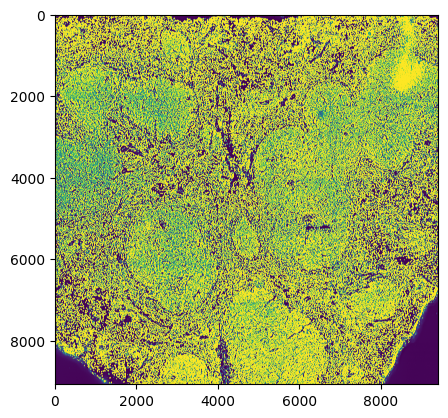

In [10]:
## this part solely for better viz, threshold not actually used
temp1 = img[:,:,0].copy()
temp1[temp1 >9000] = 9000
## end

plt.imshow(temp1) # this is nuclear image
plt.show()

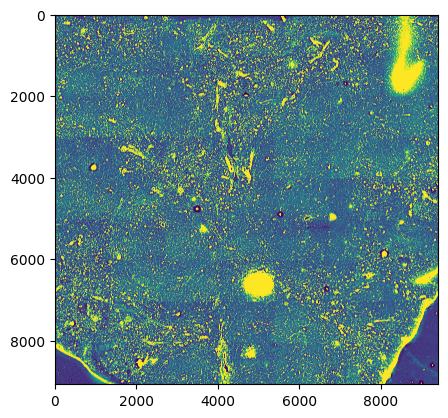

In [11]:
## this part solely for better viz, threshold not actually used
temp2 = img[:,:,1].copy()
temp2[temp2 >2000] = 2000
## end

plt.imshow(temp2) # this is membrane image
plt.show()

Note it is important to make sure the cell centroid location (in the df) is at the same scale with the image pixels

This is to make sure we can link each cell's expression profile to it's local tissue morphology information.

For example here we can visually comfirm:

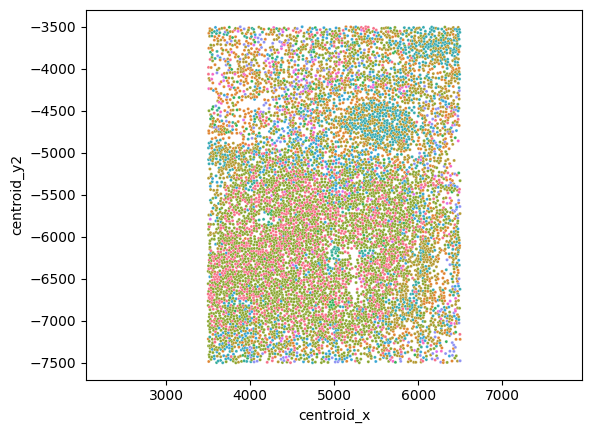

In [12]:
df['centroid_y2'] = -1 * df['centroid_y'] # this is just for seaborn plotting reverse y axis

temp = df.loc[(df.centroid_x > 3500) & (df.centroid_x < 6500) &
              (df.centroid_y > 3500) & (df.centroid_y < 7500), :]

sns.scatterplot(data = temp, x = 'centroid_x', y = 'centroid_y2', hue = 'cluster.termV2', s=5, legend=False)
plt.axis('equal')  # Ensures equal scaling for x and y axes
plt.show()

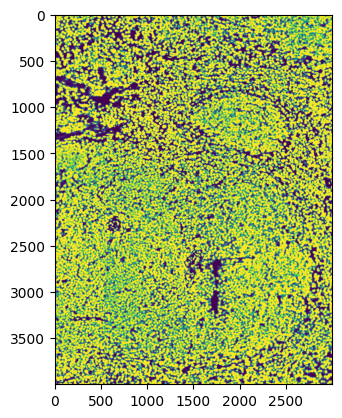

In [13]:
plt.imshow(temp1[3500:6500, 3500:7500].T) # .T here is just because plotting behaviour difference

We can see indeed the x,y locatoin in the df is same as the pixel numbers in the input image.

#### when doing seperate FOVs

This example is an stiched iamges of an entire scan. In some senarios its possible to seperate FOVs (like TMAs).

In that case (if the images were not already stiched) one could consider artificially stitching the images together (with space betweeen FOVs):

<img src="https://zenodo.org/records/14629754/files/git-1.png?download=1" alt="Image Description" width="300">

You do need to update the x y locations in the df accordingly after this.

## Step II: Initialize the object

In [14]:
## these are the expression profile (proteins)

features_list = [
    'CD45', 'Ly6C', 'TCR', 'Ly6G', 'CD19', 'CD169', 'CD106', 'CD3', 'CD1632',
    'CD8a', 'CD90', 'F480', 'CD11c', 'Ter119', 'CD11b', 'IgD', 'CD27', 'CD5',
    'CD79b', 'CD71', 'CD31', 'CD4', 'IgM', 'B220', 'ERTR7', 'MHCII', 'CD35',
    'CD2135', 'CD44', 'nucl', 'NKp46'
]


Then we can first initialize the object

In [15]:
# optionally, clean data Nans - in case data have fault
df.fillna(0, inplace=True)

murine_dataset = LENS_Dataset(df,
                              features_list=features_list,
                              nbhd_composition=15,
                              feature_neighbor=15,
                              spatial_neighbor=15,
                              path2img='./processed_images/', # location to store cropped images
                             use_transform = True) # processed image saving location - in later steps

In [16]:
import warnings
warnings.filterwarnings('ignore')

murine_dataset.initialize(cent_x="centroid_x", # x loc of cells
                          cent_y="centroid_y", # y loc of cells
                          celltype="feature_labels", # default option - run leiden to initialize the clusters
                          pca_components=25, # PCA components to use, user decide
                          cluster_res=0.5) # leiden initialization resolution

Leiden clustering identified 15 clusters as input population identity.
Calculating cell neighborhood composition matrix...
Constructing the graph...
Done!


Initialization finished. ```cluster_res = 0.5``` generated 15 clusters for neighborhood composition estimation.

Alternatively, the user could choose to use parameter ```n_clusters``` to directly set the desired cluster number.

Note we only need a coarse estimation of neighborhood composition, so we suggest the number stay on the slightly lower side (compared to actual expected populations).

Most of the time ```cluster_res = 0.5``` would work great, but in some cases (depends on the data) it would generate significantly lower cluster numbers than expected (e.g. 5 clusters but you are expecting 10-15 clusters of coarse/basic cell types). In that case you should intervene.

In [17]:
# check the training label
murine_dataset.dual_labels.shape # should be cluster number x 2

(53500, 30)

Activate to save data and crops to my drive. To save space I will instead save it to the Colab environment and only download the files I want to keep.

In [ ]:
# in case using colab
#if RUN_COLAB:
#  from google.colab import drive
#  drive.mount('/content/drive')

### Process Images

Since we will use image morphlogy informaiton, we need to first crop them to individual views for each cell.

Two parameters to note here:

```truncation```: the thresholding quantile to binarize the images.<br>

```size```: the size (pixel number) of the crop for individual cells.

Note these parameters should be dataset specific. Since tissue type could affect binarization threshold, and the pixel size is affected by imaging modalitie's pixel resolution. We suggest a reasonable range of physical size (eg. 50um - 500um). In this example the rough physical distance is ~100um.

Lets visualize the crops with our default parameters first. The user could choose to tune based on their preference.

In [18]:
size = 512
truncation = 0.8

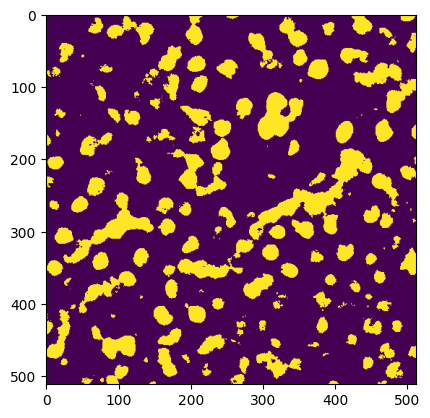

In [19]:
## example check
img_test = img[:,:,0].copy() # just showing nuclear image for example
## binarize
thresh = np.quantile(img_test, truncation)
img_test[img_test <= thresh] = 0
img_test[img_test > thresh] = 1
## quick check
example = [3500,3500] # random place
plt.imshow(img_test[(example[0] - int(size/2)):(example[0] + int(size/2)), # example of one single crop, for a cell centered at 3500,3500 (if theres a cell)
           (example[1] - int(size/2)):(example[1] + int(size/2))])

If the crop size and binarization parameters looks fine, we can proceed for producing the actual crops.

In [20]:
!pwd

/content


In [21]:
!ls

sample_data


In [22]:
# note this will create a folder with single crops images (same number of cells)
# this step (on this data) takes ~ 10mins.
murine_dataset.prepare_images(img,
                               size,
                               truncation,
                               aggr = [[0], [1]],
                               pad=1000, # pad size at boundary
                               verbose=False)
# note saving images of 50k cells will take up ~27gb space - after CNN training feel free to delete it.

Saving images...


100%|██████████| 53500/53500 [25:54<00:00, 34.42it/s]


## Step II: Train CellLENS with Morphology

There are two steps for training CellLENS:
    1. Train LENS CNN to get CNN embedding
    2. Train LENS GNN duo to get GNN embedding

### part 1: Train LENS-CNN

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
murine_celllens = CellLENS(murine_dataset,
                           device,
                           cnn_model='CNN',
                           cnn_latent_dim=128,
                           gnn_latent_dim=32 # this case the images have two channels, nuclear and membrane, thus 2
                          ) # generally these parameters no need to change ,input_channel_num=2

In [ ]:
murine_celllens.fit_lens_cnn(
                     batch_size=64,
                     learning_rate=1e-4,
                     n_epochs=5, #### NOTE: setting to 5 for saving time on this tutorial, should set to 400
                     loss_fn='MSELoss',
                     OptimizerAlg='Adam',
                     optimizer_kwargs={},
                     SchedulerAlg=None,
                     scheduler_kwargs={},
                     print_every=1000) # generally other parameters dont need to be changed - unless for specfic reason


=============Training convolutional neural network============



This tutorial was ran on one NVIDIA A40 GPU, and on a SSD disk. The estimated per-epoch time is 25s. Thus the total run time with 400 epochs would be around 2-3hrs for retraining the CNN model.

In [ ]:
murine_celllens.get_cnn_embedding(batch_size=512, # generally these parameters no need to change
                                  path2result='../CellLENS_saveouts')


=====Save CNN Embedding!============



If training is already done seperately, we can also directly load the saved out embedding

### Train LENS GNN

In [ ]:
murine_celllens.get_lens_embedding(round=5,
                                   k=32,
                                   learning_rate=1e-3,
                                   n_epochs=5000,
                                   loss_fn='MSELoss',
                                   OptimizerAlg='Adam',
                                   optimizer_kwargs={},
                                   SchedulerAlg=None,
                                   scheduler_kwargs={},
                                   verbose=True) # generally these parameters do not need to change

===Epoch 500, the training loss is 0.00498456==
===Epoch 1000, the training loss is 0.00416230==
===Epoch 1500, the training loss is 0.00382333==
===Epoch 2000, the training loss is 0.00360547==
===Epoch 2500, the training loss is 0.00345872==
===Epoch 3000, the training loss is 0.00335192==
===Epoch 3500, the training loss is 0.00326482==
===Epoch 4000, the training loss is 0.00319724==
===Epoch 4500, the training loss is 0.00313546==
===Epoch 5000, the training loss is 0.00307406==

=========Get Current Round CellLENS Embedding!============

===Epoch 500, the training loss is 0.00530262==
===Epoch 1000, the training loss is 0.00420544==
===Epoch 1500, the training loss is 0.00381713==
===Epoch 2000, the training loss is 0.00360068==
===Epoch 2500, the training loss is 0.00344289==
===Epoch 3000, the training loss is 0.00331118==
===Epoch 3500, the training loss is 0.00320360==
===Epoch 4000, the training loss is 0.00311374==
===Epoch 4500, the training loss is 0.00304908==
===Epoch 5

The GNN training part should be relatively fast. We train a total of 5 repeated times. The total time should be ~ 10 mins for this dataset.

The memory usage here is dependent on cell numbers, which the GPU need to store the cell graph. The memory usage on 50k cells is ~ 7GB.

## Step III: LENS Clustering & Visualization

In [ ]:
# the resulting CellLENS embedding is stored here:
pd.DataFrame(murine_celllens.lens_embedding)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,5.844401,1.911157,-0.546958,1.768024,1.432656,-0.564360,-4.136330,2.306166,0.897686,-0.555605,...,-0.464757,-0.837022,-0.143928,-0.154979,0.642403,0.058458,0.096161,-0.175449,0.831089,0.286551
1,4.197312,2.089943,-1.290269,1.814926,1.044515,-0.440570,-2.825010,0.906677,0.468972,-0.096239,...,-0.685327,0.250745,0.367347,0.276002,0.864122,-0.105806,0.180570,-0.537884,-0.058101,-0.266868
2,5.558903,1.243889,-0.771840,1.775306,1.250258,-0.906192,-4.406337,1.810078,0.242498,-0.255816,...,0.389315,0.479828,-0.227379,0.047980,-0.500435,-0.029826,0.621024,0.434454,-0.098949,-0.862882
3,3.421699,3.710119,0.057743,2.526644,-2.570500,-1.559040,0.553963,0.070081,-0.621371,-0.066717,...,-0.222225,0.332252,0.193886,-0.087419,0.290111,0.115013,0.032990,-0.087548,-0.336087,-0.031467
4,4.053318,1.356820,-0.430182,1.599934,0.539051,-1.087264,-3.168622,0.586256,0.535600,-0.852498,...,0.228219,-0.159367,-0.075010,0.093782,-0.126244,-0.021735,-0.021395,0.106842,-0.238448,0.108377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53495,4.161142,1.240211,-0.460724,1.654552,0.605206,-0.971051,-3.171915,0.743293,0.537721,-0.793038,...,0.171094,0.430298,-0.158405,0.054999,-0.317698,0.401499,0.058834,0.267633,0.952874,0.121203
53496,13.274980,-3.895080,5.626272,0.890486,5.798847,3.569400,0.617679,-1.495952,-9.901087,-3.069534,...,0.376840,1.287835,0.752928,-0.347939,-0.308324,-1.746488,-0.601106,0.693874,0.339467,0.096097
53497,11.043393,-2.899526,3.669623,0.795983,5.032768,2.181335,0.576424,-1.419643,-7.775449,-2.820447,...,0.937945,1.492463,0.562829,-0.561565,-0.337955,-1.164608,-0.229957,0.822493,0.363056,0.015458
53498,9.416941,-2.501784,2.871903,0.842896,4.361258,2.006821,0.415908,-1.299284,-6.852797,-2.298395,...,0.579756,1.576006,0.799664,-0.552526,-0.384203,-1.165735,-0.561071,0.515903,0.385640,0.108732


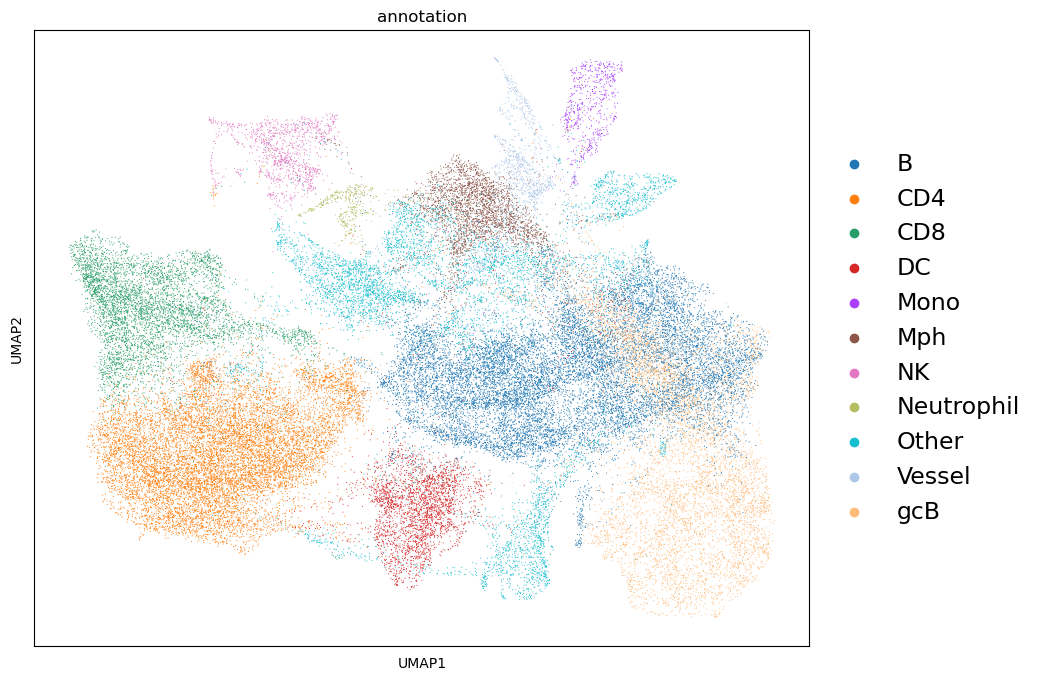

In [ ]:
# we also have a wrapper function for quick UMAP visualization of the CellLENS embedding
murine_celllens.visualize_umap(murine_celllens.lens_embedding, murine_dataset.df['cluster.termV2']) # here coloring with original cell lables

With the CellLENS embedding available, we can perform clustering and identify different cell populations.

We provide a function for Leiden clustering in our package for convinient usage.



In [ ]:
murine_celllens.get_lens_clustering(neighbor=15, # standard leiden parameter
                                    resolution=1.0, # resolution for leiden - specific
                                    entropy_threshold=0.75, # CellLENS parameter - generally no change needed
                                    concen_threshold=1, # CellLENS parameter - generally no change needed
                                    max_breaks=3, # CellLENS parameter - generally no change needed
                                    size_lim=50 # CellLENS parameter - smallest cluster size allowed
                                   )

And then we can visualize the results on the UMAP.

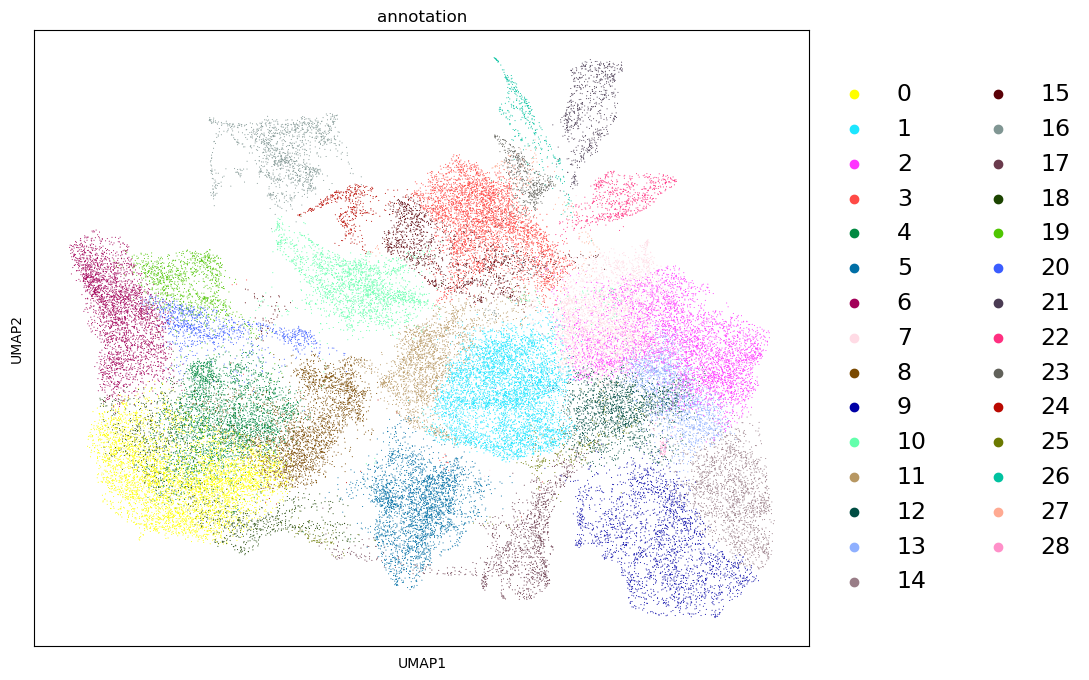

In [ ]:
murine_celllens.visualize_umap(murine_celllens.lens_embedding, murine_celllens.lens_clustering)

In [ ]:
# the clustering results can also be easily accessed here
murine_celllens.lens_clustering

['23',
 '15',
 '15',
 '1',
 '3',
 '3',
 '15',
 '10',
 '2',
 '19',
 '24',
 '3',
 '1',
 '7',
 '3',
 '15',
 '7',
 '5',
 '5',
 '19',
 '11',
 '7',
 '21',
 '3',
 '19',
 '19',
 '7',
 '15',
 '4',
 '5',
 '3',
 '19',
 '23',
 '16',
 '23',
 '19',
 '19',
 '22',
 '3',
 '23',
 '11',
 '3',
 '11',
 '3',
 '1',
 '1',
 '1',
 '3',
 '23',
 '3',
 '22',
 '3',
 '3',
 '3',
 '1',
 '16',
 '1',
 '15',
 '3',
 '10',
 '3',
 '5',
 '3',
 '4',
 '1',
 '7',
 '10',
 '3',
 '11',
 '3',
 '24',
 '3',
 '1',
 '1',
 '1',
 '10',
 '1',
 '10',
 '23',
 '11',
 '22',
 '15',
 '1',
 '3',
 '19',
 '11',
 '10',
 '4',
 '22',
 '4',
 '10',
 '10',
 '3',
 '10',
 '3',
 '7',
 '3',
 '22',
 '1',
 '19',
 '7',
 '3',
 '5',
 '5',
 '3',
 '24',
 '24',
 '11',
 '3',
 '19',
 '10',
 '1',
 '3',
 '7',
 '3',
 '2',
 '2',
 '1',
 '5',
 '3',
 '5',
 '4',
 '7',
 '1',
 '1',
 '15',
 '1',
 '4',
 '3',
 '23',
 '5',
 '23',
 '19',
 '10',
 '3',
 '10',
 '23',
 '23',
 '2',
 '11',
 '22',
 '21',
 '19',
 '8',
 '4',
 '11',
 '3',
 '3',
 '23',
 '3',
 '19',
 '11',
 '23',
 '4',
 '8',
 

One could easily save this result out and perform your various downstream analysis.